In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

### Data load

In [ ]:
X_train = np.load('data/DRFP/X_train_DRFP.npy')
X_test = np.load('data/DRFP/X_test_DRFP.npy')
X_val = np.load('data/DRFP/X_val_DRFP.npy')

In [ ]:
train = pd.read_csv('data/train.csv', delimiter=',')
test = pd.read_csv('data/test.csv', delimiter=',')
val = pd.read_csv('data/val.csv', delimiter=',')

In [ ]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values

In [ ]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
X_val = np.squeeze(X_val)

In [ ]:
df_test1nn = pd.read_csv('data/DRFP/df_test1nn.csv', delimiter=',')

In [ ]:
y_pred_test1nn = np.load('data/DRFP/y_pred_test_1nn.npy')

### Evaluation

In [ ]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [ ]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [ ]:
df_test1nn = pd.merge(df_test1nn, df_class[['CLASS-ID', 'TRANSFORM_ID']], on='CLASS-ID', how='left')

In [ ]:
df_test1nn

In [ ]:
df_test1nn['SUPER_TRANSFORM_ID'] = df_test1nn['TRANSFORM_ID'].str.extract(r'\((.*?)\)')

In [ ]:
df_test1nn

In [ ]:
def weighted_mean(values, weights):
    return (values * weights).sum() / weights.sum()

In [ ]:
grouped = df_test1nn.groupby('SUPER_TRANSFORM_ID')

grouped_metrics = grouped.apply(lambda x: pd.Series({
    'weighted_precision': weighted_mean(x['precision'], x['test_support']),
    'weighted_recall': weighted_mean(x['recall'], x['test_support']),
    'weighted_f1-score': weighted_mean(x['f1-score'], x['test_support']),
    'total_test_support': x['test_support'].sum(),
    'total_train_support': x['train_support'].sum(),
    'class_count': len(x)
}))

In [ ]:
grouped_metrics.sort_values(by=['SUPER_TRANSFORM_ID'])

In [ ]:
# Calculate macro average for precision, recall, and f1-score
macro_precision2 = df_test1nn['precision'].mean()
macro_recall2 = df_test1nn['recall'].mean()
macro_f12 = df_test1nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision2 = (df_test1nn['precision'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_recall2 = (df_test1nn['recall'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_f12 = (df_test1nn['f1-score'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()

In [19]:
output1 = f"""
Macro-averages:
- Precision: {macro_precision2:.4f}
- Recall: {macro_recall2:.4f}
- F1-score: {macro_f12:.4f}

Weighted-averages:
- Precision: {weighted_precision2:.4f}
- Recall: {weighted_recall2:.4f}
- F1-score: {weighted_f12:.4f}
"""

In [20]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_test1nn)}')

Accuracy: 0.926952026843203


In [21]:
print(output1)


Macro-averages:
- Precision: 0.8903
- Recall: 0.8603
- F1-score: 0.8675

Weighted-averages:
- Precision: 0.9279
- Recall: 0.9270
- F1-score: 0.9266



In [22]:
summary_stats = df_test1nn[["precision", "recall", "f1-score", "test_support", "train_support"]].describe()
summary_stats

,precision,recall,f1-score,test_support,train_support
count,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000
mean,0.890264,0.860311,0.867475,254.665127,1851.890685
std,0.182265,0.196462,0.182413,1212.528218,9034.637418
min,0.000000,0.000000,0.000000,1.000000,7.000000
25%,0.875000,0.807190,0.833333,6.000000,39.000000
50%,0.953586,0.928144,0.924370,24.000000,160.000000
75%,1.000000,1.000000,0.980642,110.500000,811.000000
max,1.000000,1.000000,1.000000,24966.000000,185024.000000


In [23]:
low_f1_reactions = df_test1nn[df_test1nn['f1-score'] < df_test1nn['f1-score'].quantile(0.25)].head(10)

### Wrong predict evaluation in details

In [24]:
class_to_transform_id = pd.Series(df_class['TRANSFORM_ID'].values,index=df_class['CLASS-ID']).to_dict()

In [25]:
y_pred_flattened = y_pred_test1nn.flatten() 

In [26]:
mismatches = y_pred_flattened != y_test

full_comparison_df = pd.DataFrame({
    'CLASS-ID': y_test,
    'CLASS-ID-predict': y_pred_flattened,
    'Misclassified': mismatches
})

misclassified_df = full_comparison_df[full_comparison_df['Misclassified'] == True].sort_values(by=['CLASS-ID', 'CLASS-ID-predict'])

In [27]:
counts = misclassified_df.groupby(['CLASS-ID', 'CLASS-ID-predict']).size().reset_index(name='Count')
top_counts = (counts.sort_values(by=['CLASS-ID', 'Count'], ascending=[True, False])
             .groupby('CLASS-ID')
             .head(3))

In [28]:
reshaped_df = pd.DataFrame()
for i, group in top_counts.groupby('CLASS-ID'):
    reshaped_row = {'CLASS-ID': i}
    for j, (index, row) in enumerate(group.iterrows(), start=1):
        reshaped_row[f'Top{j}_CLASS-ID-predict'] = row['CLASS-ID-predict']
        reshaped_row[f'Top{j}_Count'] = row['Count']
    reshaped_df = reshaped_df.append(reshaped_row, ignore_index=True)
reshaped_df = reshaped_df[['CLASS-ID'] + [col for col in reshaped_df.columns if col != 'CLASS-ID']].fillna(0).astype(int)

In [29]:
reshaped_df['Top1_MISTRANSFORM_ID'] = reshaped_df['Top1_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top2_MISTRANSFORM_ID'] = reshaped_df['Top2_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top3_MISTRANSFORM_ID'] = reshaped_df['Top3_CLASS-ID-predict'].map(class_to_transform_id)

In [30]:
df_low = pd.merge(low_f1_reactions, reshaped_df[['CLASS-ID', 'Top1_MISTRANSFORM_ID', 'Top1_Count', 'Top2_MISTRANSFORM_ID', 'Top2_Count', 'Top3_MISTRANSFORM_ID', 'Top3_Count']], on='CLASS-ID', how='left')

In [31]:
df_low

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID,SUPER_TRANSFORM_ID,Top1_MISTRANSFORM_ID,Top1_Count,Top2_MISTRANSFORM_ID,Top2_Count,Top3_MISTRANSFORM_ID,Top3_Count
0,72,0.819018,0.813409,0.816204,3505,23643,oxidation of (CH2)2 to C=C,(ABOXIDAT)1.1.1,ABOXIDAT,(ACADD)1.1.1,153,(AAREDUCT)4.4.2,87,(AAREDUCT)4.3,36
1,5,0.717607,0.740326,0.728790,3127,23357,reduction of aldehydes to alcohols,(AAREDUCT)1.1.1,AAREDUCT,"(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",250,"(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",231,(AVNAMEDR)Corey-Suggs,216
2,848,0.789173,0.842575,0.815000,2128,16370,condensation of heteroaryl carboxylic acids wi...,(AHCONDEN)1.3.1,AHCONDEN,(AQCLEAV1)1.1,265,(AHCONDEN)1.1.1,27,(AAREDUCT)1.3.5,6
3,109,0.782669,0.691373,0.734194,1646,12611,"Dess-Martin ketone synthesis, Dess-Martin oxid...","(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",ABOXIDAT,(AVNAMEDR)Corey-Suggs,163,"(ABOXIDAT)5.2.1, (AVNAMEDR)Swern1.2",90,(AHCONDEN)1.1.1,29
4,1331,0.564826,0.564487,0.564656,1667,12096,Corey-Suggs Reagent,(AVNAMEDR)Corey-Suggs,AVNAMEDR,(AAREDUCT)1.1.1,178,"(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",132,"(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",97
5,99,0.567708,0.528028,0.547150,1445,10979,"Dess-Martin aldehyde synthesis, Dess-Martin ox...","(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",ABOXIDAT,(AAREDUCT)1.1.1,290,"(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",236,(AVNAMEDR)Corey-Suggs,104
6,77,0.788978,0.786696,0.787835,1383,9051,oxidation of methylene group to ketones,(ABOXIDAT)1.3.2,ABOXIDAT,(AAREDUCT)1.2.4,150,(AAREDUCT)C.2.1,13,(AHCONDEN)1.1.1,12
7,12,0.795971,0.847165,0.820771,1446,8567,reduction of ketones to methylene group,(AAREDUCT)1.2.4,AAREDUCT,(ABOXIDAT)1.3.2,138,(AHCONDEN)1.1.1,9,(ACADD)1.1.1,4
8,97,0.449362,0.539877,0.490478,978,7239,"Swern aldehyde synthesis, Swern oxidation of a...","(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",ABOXIDAT,(AAREDUCT)1.1.1,185,"(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",164,(AVNAMEDR)Corey-Suggs,69
9,44,0.765393,0.758947,0.762156,950,6185,"alkene reduction of alpha,beta unsaturated car...",(AAREDUCT)4.4.2,AAREDUCT,(ABOXIDAT)1.1.1,99,(ACADD)1.1.1,24,(AAREDUCT)4.3,8


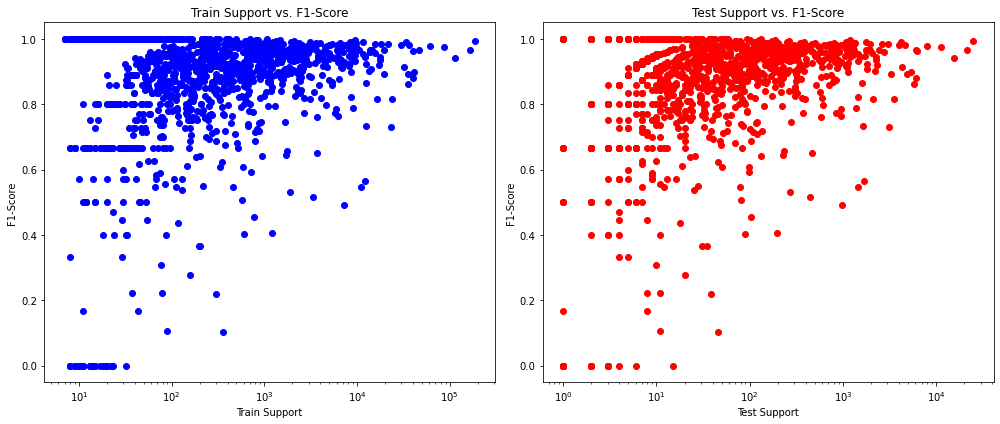

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(df_test1nn['train_support'], df_test1nn['f1-score'], color='blue')
ax1.set_title('Train Support vs. F1-Score')
ax1.set_xlabel('Train Support')
ax1.set_ylabel('F1-Score')
ax1.set_xscale('log')  # Set x-axis to log scale

ax2.scatter(df_test1nn['test_support'], df_test1nn['f1-score'], color='red')
ax2.set_title('Test Support vs. F1-Score')
ax2.set_xlabel('Test Support')
ax2.set_ylabel('F1-Score')
ax2.set_xscale('log')  # Set x-axis to log scale

plt.tight_layout()
plt.show()